In [1]:
import pandas as pd
import torch

from netam import framework, models

/Users/matsen/mambaforge/envs/epam/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

shmoof_path = "/Users/matsen/data/shmoof_edges_11-Jan-2023_NoNode0_iqtree_K80+R_masked.csv"
df = pd.read_csv(shmoof_path)

df = df[df["parent"] != df["child"]]

df["sample_id"].value_counts()

sample_id
326651    22424
326713    13186
327059     4686
316188     3067
326797     3028
326780     1573
326737      442
326650      324
326907      286
Name: count, dtype: int64

In [3]:
# set nickname to be the last two characters of sample_id
df["nickname"] = df["sample_id"].astype(str).str[-2:]

for small_nickname in ["80", "37", "50", "07"]:
    df.loc[df["nickname"] == small_nickname, "nickname"] = "small"

nicknames = df["nickname"].unique()

df["nickname"].value_counts()

nickname
51       22424
13       13186
59        4686
88        3067
97        3028
small     2625
Name: count, dtype: int64

In [5]:
train_losses = []
val_losses = []

kmer_length=5
max_length=410
shmoof_data_path = "/Users/matsen/data/shmoof_edges_11-Jan-2023_NoNode0_iqtree_K80+R_masked.csv"

for nickname in nicknames:
    train_df, val_df = framework.load_shmoof_dataframes(shmoof_data_path, val_nickname=nickname)
    train_dataset = framework.SHMoofDataset(train_df, kmer_length=kmer_length, max_length=max_length)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1024, shuffle=False)
    val_dataset = framework.SHMoofDataset(val_df, kmer_length=kmer_length, max_length=max_length)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1024, shuffle=False)

    print(f"evaluating on {nickname}...")
    model = models.SHMoofModel(train_dataset)
    burrito = framework.Burrito(train_dataset, val_dataset, model, batch_size=1024, learning_rate=0.1, min_learning_rate=1e-4, l2_regularization_coeff=1e-6)
    train_losses.append(burrito.process_data_loader(train_loader, train_mode=False))
    val_losses.append(burrito.process_data_loader(val_loader, train_mode=False))

df = pd.DataFrame({"nickname of val set": nicknames, "train_loss": train_losses, "val_loss": val_losses})
df
    

evaluating on split...
evaluating on 51...
evaluating on small...
evaluating on 13...


,nickname of val set,train_loss,val_loss
0,split,0.087159,0.085409
1,51,0.088606,0.091075
2,small,0.090905,0.077919
3,13,0.084682,0.097237


In [4]:
import pandas as pd
import matplotlib.pyplot as plt

def mutation_count_of_row(row):    
    return sum(
        1 for p, c in zip(row["parent"], row["child"]) if p != c and p != "N" and c != "N"
    )    

mutation_counts = {nickname: [] for nickname in nicknames}

for nickname in nicknames:
    _, val_df = framework.load_shmoof_dataframes(shmoof_path, val_nickname=nickname)  # Load the dataframe
    val_df['mutation_count'] = val_df.apply(mutation_count_of_row, axis=1)
    mutation_counts[nickname] = val_df['mutation_count'].tolist()

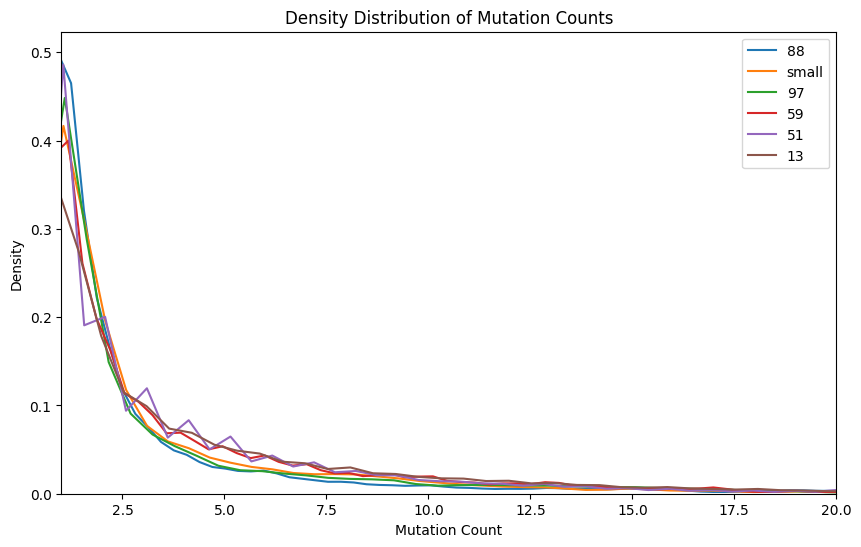

In [5]:
import seaborn as sns

plt.figure(figsize=(10, 6))
for nickname, counts in mutation_counts.items():
    sns.kdeplot(counts, label=nickname, bw_adjust=0.5)

plt.xlim(1, 20)
plt.xlabel('Mutation Count')
plt.ylabel('Density')
plt.title('Density Distribution of Mutation Counts')
plt.legend()
plt.show()


In [16]:
nicknames.sort()
nicknames

array(['13', '51', '59', '88', '97', 'small'], dtype=object)